In [14]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [25]:
import time
start_time = time.time()
training = 152
test = 65
start_balance = 100000

pd_data1_test=data1[training:training+test]
pd_data2_test=data2[training:training+test]

In [26]:
#Initialize state and set benchmarking model
total_Prof=[]
done=False

Act_datasize = test
batch_size = 32

# Take Opening price in a new variable
data1_test=pd_data1_test['Open']
data2_test=pd_data2_test['Open']
data1_date=pd_data1_test.index.tolist()

data1_MACD_test=pd_data1_test['MACD']
data2_MACD_test=pd_data2_test['MACD']

Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_test[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_test[0]))
Act_Bench_Open_cash=start_balance/2
open_cash_t2= Act_Bench_Open_cash

initial_cash = 100000

In [27]:
### Program to calculate benchmark profit
#sell 10% of stock in 10 intervals

interval=int(Act_datasize/10)
Total_Stock1_Amount= 0
Total_Stock2_Amount= 0
stocks2Value = 0
stocks1Value = 0

Act_stocks1=np.floor(Act_Bench_Stock1_Bal /10)
Act_stocks2=np.floor(Act_Bench_Stock2_Bal /10)
#print(str(Act_stocks1))
#print(str(Act_stocks2))

remaining_stock1=Act_Bench_Stock1_Bal
remaining_stock2=Act_Bench_Stock2_Bal
ttl=0

Benchmark_Port_Value=[]

for j in range (interval,Act_datasize+1,interval):
        # print("closing prices : " + str(data1_train[j-1]) )
        Price_closing_Stock1=data1_test[j-1]
        Price_closing_Stock2=data2_test[j-1]

        date_stock1=data1_date[j-1].strftime('%Y-%m-%d')
        #print(date_stock1)

        stocks1Value= Act_stocks1 * Price_closing_Stock1
        stocks2Value= Act_stocks2 * Price_closing_Stock2
        remaining_stock1=remaining_stock1-Act_stocks1
        remaining_stock2=remaining_stock2-Act_stocks2
        #print("J is:"+ str(j))


        Stock1_Port_value=remaining_stock1*Price_closing_Stock1
        Stock2_Port_value=remaining_stock2*Price_closing_Stock2
        Act_Bench_Open_cash=Act_Bench_Open_cash+stocks1Value+stocks2Value #Adding 10% sold value into open cash

        Total_Portfolio_value=Act_Bench_Open_cash+Stock1_Port_value+Stock2_Port_value
        Benchmark_Port_Value.append([date_stock1,Total_Portfolio_value])


#print ("total_Test_Benchmark_amount : " +  str(Total_Portfolio_value))

Test_Benchmark_Portfolio_Value= Total_Portfolio_value


print("Benchmark_Profit is  ", round(Test_Benchmark_Portfolio_Value, 2)," with remaining Apple Stocks:  " + str(remaining_stock1) +
      " and remaining Amazon stocks:  "+ str(remaining_stock2) )
Benchmark_Port_Value.insert(0,['2023-09-19', 100000])

Benchmark_Profit is   100039.38  with remaining Apple Stocks:  0.0 and remaining Amazon stocks:  0.0


In [28]:
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

In [29]:
#Actual run
episode_count=0

#Define arrays to store per episode values 
Act_total_Prof=[]
Act_total_stock1bal=[]
Act_total_stock2bal=[]
Act_total_open_cash=[]
Act_total_port_value=[]
Act_total_days_played=[]
actions_done_perday=[]
portfolio_value=[]

In [30]:
from keras.models import load_model

model_name='model_ep30'

model = load_model("models/" + model_name)

In [31]:
for e in range(1): 

    Bal_stock1_t2=Act_Bench_Stock1_Bal
    Bal_stock2_t2=Act_Bench_Stock2_Bal
    done=False
    open_cash_t2=open_cash_t2
    total_profit = 0
    reward = 0
    
    #Initialize Agent
    agent_test = Agent(8, is_eval=True, model_name=model_name)

    agent_test.inventory1 =[]
    agent_test.inventory2 =[]
    for i in range(Bal_stock1_t2):
        agent_test.inventory1.append(data1_test[0])
    for i in range(Bal_stock2_t2):
        agent_test.inventory2.append(data2_test[0]) 
    
    #Timestep delta to make sure that with time reward increases for taking action
    timestep_delta=0
    
    #Running episode over all days in the datasize
    for t in range(Act_datasize):
        print("..........")
        
        print(pd_data1_test.iloc[t,0])
        state_class_obj = State(data1_test, data2_test, data1_MACD_test, data2_MACD_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
        state_array_obj = state_class_obj.getState()
        action = agent_test.act(state_array_obj)
        
        print("Total portfolio value: " + str(state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   + "  stock 2 number: " + str(len(agent_test.inventory2)) + "  open cash: "+str(state_class_obj.open_cash))

        if action == 0:  #buy stock 1
            if state_class_obj.Stock1Price > state_class_obj.open_cash:
                reward = -20000
                done = True
                #end episode
                     
            else:
                #print("In Buy stock 1")
                agent_test.inventory1.append(data1_test[t])
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock1Price 
                if (state_class_obj.open_cash<500):
                  reward=-20000
                elif state_class_obj.MACD_stock1 > 0:
                  reward = abs(state_class_obj.MACD_stock1) * 10000  
                elif state_class_obj.MACD_stock1 < 0:
                  reward = -abs(state_class_obj.MACD_stock1) * 10000  
                
        if action == 1:  #sell stock 1
            if state_class_obj.Stock1Blnc <1 :
                reward = -20000
                done = True
                #end episode
            else:
                bought_price1=agent_test.inventory1.pop(0)
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock1Price #State[0] is the price of stock 1.
                if (state_class_obj.Stock1Blnc<10):
                  reward=-20000
                elif state_class_obj.MACD_stock1 < 0:
                  reward = abs(state_class_obj.MACD_stock1) * 10000  
                elif state_class_obj.MACD_stock1 > 0:
                  reward = -abs(state_class_obj.MACD_stock1) * 10000
                
        if action == 2:
            if (state_class_obj.open_cash<0.1*start_balance):
                reward = 20000
            elif abs(state_class_obj.MACD_stock1) <= 1 and abs(state_class_obj.MACD_stock2) <= 1:
                reward = 10000  
            elif abs(state_class_obj.MACD_stock1) > 1 or abs(state_class_obj.MACD_stock2) > 1:
                reward = -abs(state_class_obj.MACD_stock1) * 5000 - abs(state_class_obj.MACD_stock2) * 5000  

            Bal_stock1_t2= len(agent_test.inventory1)
            Bal_stock2_t2=len(agent_test.inventory2)
            open_cash_t2= open_cash_t2
        
        
        if action == 3:  #buy stock 2
            if state_class_obj.Stock2Price > state_class_obj.open_cash:
                reward = -20000
                done = True
 
            else:
                #print("In Buy stock 2")
                agent_test.inventory2.append(data2_test[t])
                Bal_stock1_t2=len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock2Price
                
                if (state_class_obj.open_cash<500):
                  reward=-20000
                elif state_class_obj.MACD_stock2 > 0:
                  reward = abs(state_class_obj.MACD_stock2) * 10000  
                elif state_class_obj.MACD_stock2 < 0:
                  reward = -abs(state_class_obj.MACD_stock2) * 10000

        
        if action == 4:  #sell stock 2
            if state_class_obj.Stock2Blnc <1 :
                reward = -20000
                done = True

            else:
                #print("In sell stock 2")
                bought_price2=agent_test.inventory2.pop(0)
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock2Price
                
                if (state_class_obj.Stock2Blnc<10):
                  reward=-20000
                elif state_class_obj.MACD_stock2 < 0:
                  reward = abs(state_class_obj.MACD_stock2) * 10000 
                elif state_class_obj.MACD_stock2 > 0:
                  reward = -abs(state_class_obj.MACD_stock2) * 10000 

                total_profit += state_class_obj.Stock2Price - bought_price2

        if t == Act_datasize-1:
            done=True
            next_state_class_obj=State(data1_test, data2_test, data1_MACD_test, data2_MACD_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
            next_state_array_obj=next_state_class_obj.getState()
        else:
            next_state_class_obj=State(data1_test, data2_test, data1_MACD_test, data2_MACD_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t+1)
            next_state_array_obj=next_state_class_obj.getState()
            
        #print("Action is "+str(action)+" reward is" + str(reward))
        
        actions_done_perday.append(action)
        portfolio_value.append(next_state_class_obj.portfolio_value)

        if done==True:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(next_state_class_obj.portfolio_value - initial_cash))
            print("Total No. of days played: " + str(t)+ "  out of overall days:  " + str(Act_datasize))
            print("Total portfolio value: " + str(next_state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   +"  stock 2 number: "+str(len(agent_test.inventory2))+"  open cash: "+str(next_state_class_obj.open_cash))

            Act_total_Prof.append(total_profit)
            Act_total_stock1bal.append(len(agent_test.inventory1))
            Act_total_stock2bal.append(len(agent_test.inventory2))
            Act_total_open_cash.append(state_class_obj.open_cash)
            Act_total_port_value.append(state_class_obj.portfolio_value)
            Act_total_days_played.append(t)


            print("--------------------------------")
            state_class_obj.reset()
            break

..........
177.52000427246094
1/1 [==============================] - 0s 210ms/step
Total portfolio value: 99818.80004882812  stock 1 number: 140  stock 2 number: 180  open cash: 50000.0
..........
179.25999450683594
1/1 [==============================] - 0s 20ms/step
Total portfolio value: 100035.39978027344  stock 1 number: 140  stock 2 number: 180  open cash: 50000.0
..........
174.5500030517578
1/1 [==============================] - 0s 22ms/step
Total portfolio value: 98186.20086669922  stock 1 number: 140  stock 2 number: 180  open cash: 50000.0
..........
174.6699981689453
1/1 [==============================] - 0s 27ms/step
Total portfolio value: 98053.59985351562  stock 1 number: 140  stock 2 number: 180  open cash: 50000.0
..........
174.1999969482422
1/1 [==============================] - 0s 23ms/step
Total portfolio value: 97672.79968261719  stock 1 number: 140  stock 2 number: 180  open cash: 50000.0
..........
174.82000732421875
1/1 [==============================] - 0s 24ms

In [12]:
len(portfolio_value)

65

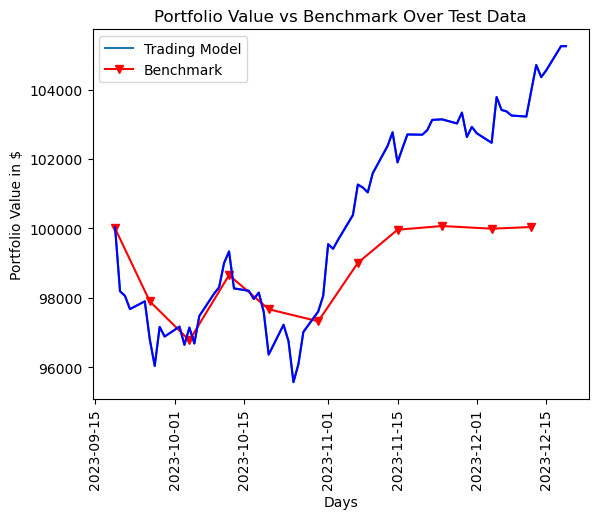

In [32]:
# Test Stock Prices and actions taken by agent Stock Plot
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

pd_bm=pd.DataFrame.from_records(Benchmark_Port_Value)
pd_bm[0]=pd.to_datetime(pd_bm[0], format='%Y/%m/%d')

x1 = np.array(data1_date)
y1 = portfolio_value

x2=pd_bm[0]
y2=pd_bm[1]


plt.title("Portfolio Value vs Benchmark Over Test Data")
plt.xlabel("Days")
plt.ylabel("Portfolio Value in $")

plt.plot(x1,y1)
plt.plot_date(x2, y2, c = 'red', marker='v', linestyle='-')


#plt.plot(x1, z, '-', color='black');
plt.plot(x1, y1, '-', color='blue');

#plt.scatter(x1,Benchmark_Port_Value,marker='o')

plt.legend(('Trading Model', 'Benchmark'))
plt.xticks(rotation='vertical')
plt.show()